# **Sentiment Analysis**

This project is to conduct sentiment analysis on Amazon Fashion reviews, to classify the reviews into 'positive', 'negative', 'neutral' category. 

In the first step Natural language processing is used, more specifically the VADER approach. Here the data is analysed and given numeric socres of positive, negative, neutral and a combimed weight of the three, called compound. 
Furthermore, the compound scores are used to label the individual reviews as, 'positive', 'negative', and 'neutral' 

In the second step a Machine learning model is developed based on the 'vader-lables'. This is achieved by utilising NLP process of TF-IDF (Text Frequency - Inverse Document Frequency), which converts the text from the reviews into numerical values, which are furhter used to train a SVM model. 

In the third step VADER scores and the ML score will be comepared to see the performance of the created model.

Lastly we will draw conclusions about the model performance and see how it can be improved in the future.


In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import nltk



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/amazon-fashion-huggingfacedataset/Amazon_Fashion.jsonl


In [2]:
# Loading the dataset 
file_path = '/kaggle/input/amazon-fashion-huggingfacedataset/Amazon_Fashion.jsonl'

data = pd.read_json(file_path, lines = True)

In [3]:
# Data Exploration 

data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09 00:06:34.489,3,True
1,5,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20 01:04:06.701,0,True
2,2,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23 01:33:48.000,3,True
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31 20:57:27.095,2,True
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13 14:29:26.000,0,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500939 entries, 0 to 2500938
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int64         
 1   title              object        
 2   text               object        
 3   images             object        
 4   asin               object        
 5   parent_asin        object        
 6   user_id            object        
 7   timestamp          datetime64[ns]
 8   helpful_vote       int64         
 9   verified_purchase  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 174.1+ MB


In [5]:
data.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

In [6]:
# Converting datetime 

data['timestamp'] = pd.to_datetime(data['timestamp'])

data['date'] = data['timestamp'].dt.date
data['time'] = data['timestamp'].dt.time

data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,time
0,5,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09 00:06:34.489,3,True,2020-01-09,00:06:34.489000
1,5,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20 01:04:06.701,0,True,2020-12-20,01:04:06.701000
2,2,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23 01:33:48.000,3,True,2015-05-23,01:33:48
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31 20:57:27.095,2,True,2018-12-31,20:57:27.095000
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13 14:29:26.000,0,True,2015-08-13,14:29:26


In [7]:
# Filtering columns that are necessary for the sentiment analysis. 

selected_columns = ['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id', 'date','time']
filt_data = data[selected_columns]

In [8]:
filt_data.head()

,rating,title,text,asin,parent_asin,user_id,date,time
0,5,Pretty locket,I think this locket is really pretty. The insi...,B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09,00:06:34.489000
1,5,A,Great,B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20,01:04:06.701000
2,2,Two Stars,One of the stones fell out within the first 2 ...,B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23,01:33:48
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31,20:57:27.095000
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13,14:29:26


In [9]:
# Exploring the data

print(filt_data['rating'].value_counts())

rating
5    1426268
4     352327
1     303411
3     245471
2     173462
Name: count, dtype: int64


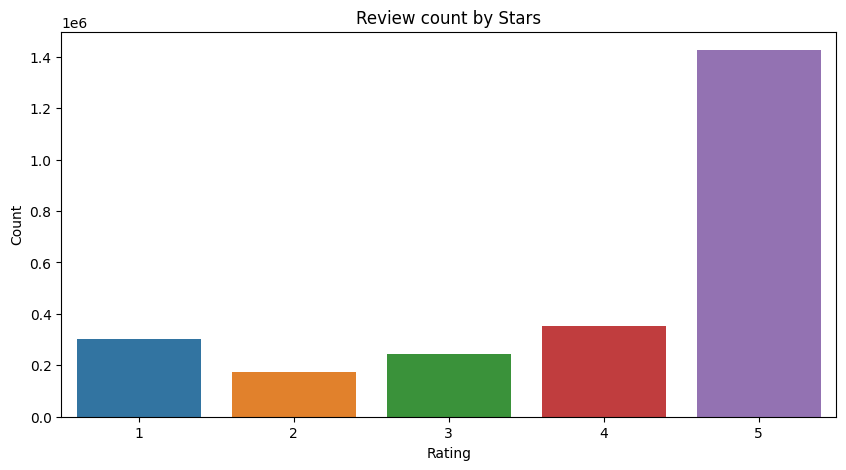

In [10]:
# Visualising this data

plt.figure(figsize = (10,5))
sns.barplot(x = filt_data['rating'].value_counts().index, y = filt_data['rating'].value_counts().values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Review count by Stars")
plt.show()

**VADER Analysis** 

VADER stands for Valence Aware Dictionary and sEntiment Reasoner, it uses Bag of word approach, where the text to be analysed is broken down to its original components.

In [11]:
# Checking for null values

print(filt_data.isnull().sum())

rating         0
title          0
text           0
asin           0
parent_asin    0
user_id        0
date           0
time           0
dtype: int64


In [12]:
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer

/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [13]:
sscore = SentimentIntensityAnalyzer()

# Using polarity_scores to get the sentiment scores
# Testing it on an example review 

example = filt_data['text'][44]
print(example)

Absolutely Adorable and perfect for church! Thank you so much


In [14]:
sscore.polarity_scores(example)

{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.882}

The sentiment of the example review is mostly positive

In [15]:
# Trying it out on a review which is accompanied with a low rating

example2 = filt_data[filt_data['rating'] == 1][['text','rating']]
tester = example2.head(1)
print(tester)
# extracting just the text
tester_text = tester['text'].values[0]

                                                text  rating
3  Crappy socks. Money wasted. Bought to wear wit...       1


In [16]:
sscore.polarity_scores(tester_text)

{'neg': 0.325, 'neu': 0.574, 'pos': 0.1, 'compound': -0.6908}

The sentiment (compund) score of -0.6908, indicates that the text is of an nagtive sentiment

In [17]:
tqdm.pandas() #To show the progress bar 

In [18]:
# Applying sentiment analysis to the entire dataset

sentiment_scores_vader = [sscore.polarity_scores(text) for text in tqdm(filt_data['text'], desc = "Processing Sentiment")]


Processing Sentiment: 100%|██████████| 2500939/2500939 [14:46<00:00, 2820.82it/s]


In [19]:
vader_df = pd.DataFrame(sentiment_scores_vader)
filt_data = pd.concat([filt_data,vader_df], axis = 1)

In [20]:
print(filt_data [['text','rating','neg','neu','pos','compound']].head())

                                                text  rating    neg    neu  \
0  I think this locket is really pretty. The insi...       5  0.039  0.750   
1                                              Great       5  0.000  0.000   
2  One of the stones fell out within the first 2 ...       2  0.000  1.000   
3  Crappy socks. Money wasted. Bought to wear wit...       1  0.325  0.574   
4  I LOVE these glasses!  They fit perfectly over...       5  0.000  0.684   

     pos  compound  
0  0.211    0.8532  
1  1.000    0.6249  
2  0.000    0.0000  
3  0.100   -0.6908  
4  0.316    0.9675  


In [21]:
# Before visuliasing the sentiment distribution,
# we add a new column "sentiment_label" based on the compund scores from VADER analysis

def classify_sentiment (scores):
    conditions = [
        scores >= 0.05, #Positive
        scores <= -0.05 #Negative
    ]
    choices = ["positive","negative"]
    return np.select(conditions, choices, default = "neutral")
# Applying the classification function to the dataset

filt_data['vader_sentiment'] = classify_sentiment(filt_data['compound'].values)


In [22]:
filt_data.head()

,rating,title,text,asin,parent_asin,user_id,date,time,neg,neu,pos,compound,vader_sentiment
0,5,Pretty locket,I think this locket is really pretty. The insi...,B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09,00:06:34.489000,0.039,0.750,0.211,0.8532,positive
1,5,A,Great,B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20,01:04:06.701000,0.000,0.000,1.000,0.6249,positive
2,2,Two Stars,One of the stones fell out within the first 2 ...,B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23,01:33:48,0.000,1.000,0.000,0.0000,neutral
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31,20:57:27.095000,0.325,0.574,0.100,-0.6908,negative
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13,14:29:26,0.000,0.684,0.316,0.9675,positive


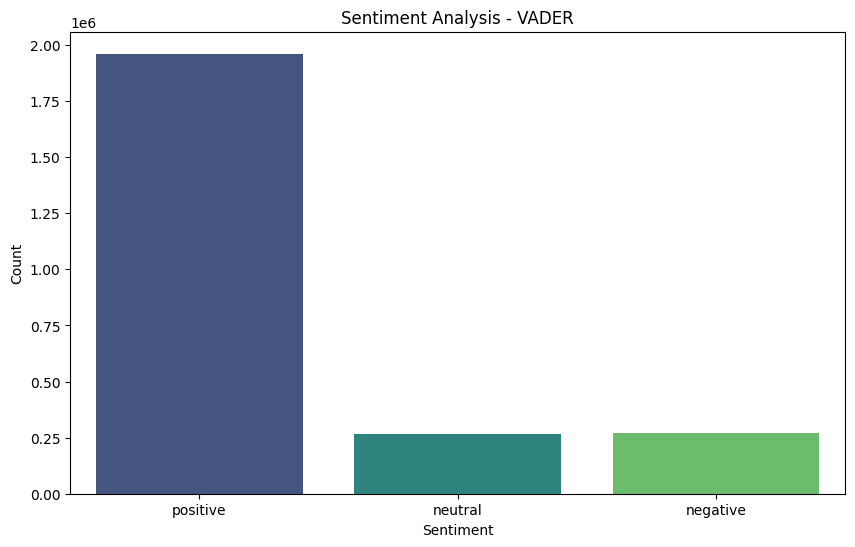

In [23]:
# Visualising the sentiment distribution 

plt.figure(figsize = (10,6))
sns.countplot(x = filt_data['vader_sentiment'], palette = 'viridis')

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Analysis - VADER")
plt.show()

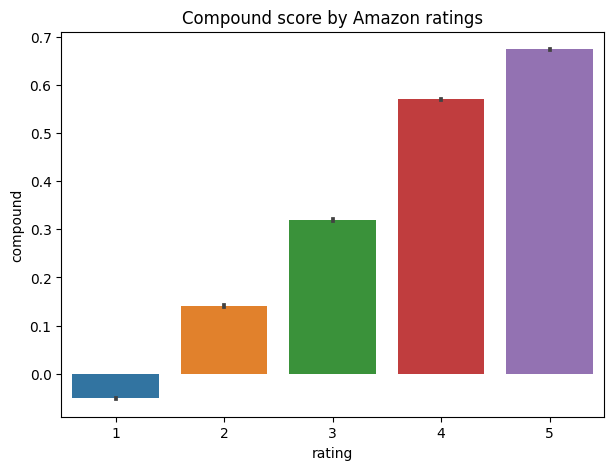

In [24]:
plt.figure(figsize = (7,5))
sns.barplot(data = filt_data, x = 'rating', y = 'compound')
plt.title("Compound score by Amazon ratings")
plt.show()

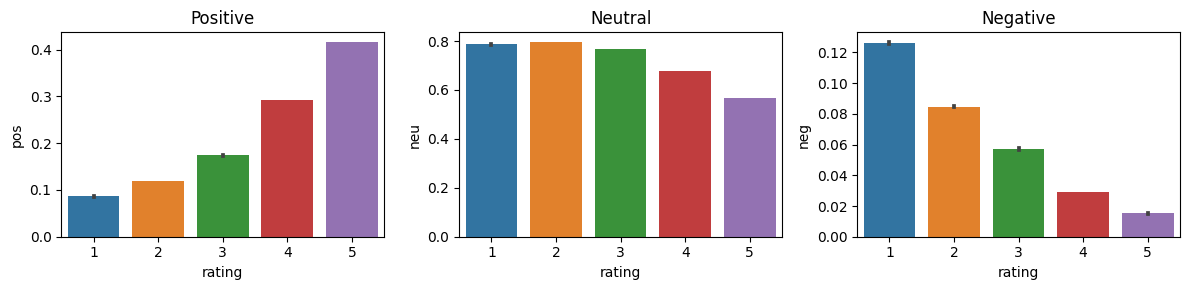

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data= filt_data, x='rating', y='pos', ax=axs[0])
sns.barplot(data= filt_data, x='rating', y='neu', ax=axs[1])
sns.barplot(data= filt_data, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Now with Vader analysis done we create and train an ML model to compare the sentiment recognition performance of VADER approcah with that of a process which uses TF-IDF + ML. 

TF-IDF stands for Term Frequency-Inverse Document Frequency, the methond using NLP converts text to numerical values. 

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer  # To convert text to numerical values
from sklearn.model_selection import train_test_split # To split the data for ML-model trainig 


from sklearn.svm import SVC  # ML-model 
from sklearn.metrics import classification_report, accuracy_score # To evaluate the model performance

In [27]:
ml_data = filt_data.copy() # Creating an independent copy of the dataset for better usability 

ml_data.head()

,rating,title,text,asin,parent_asin,user_id,date,time,neg,neu,pos,compound,vader_sentiment
0,5,Pretty locket,I think this locket is really pretty. The insi...,B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09,00:06:34.489000,0.039,0.750,0.211,0.8532,positive
1,5,A,Great,B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20,01:04:06.701000,0.000,0.000,1.000,0.6249,positive
2,2,Two Stars,One of the stones fell out within the first 2 ...,B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23,01:33:48,0.000,1.000,0.000,0.0000,neutral
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31,20:57:27.095000,0.325,0.574,0.100,-0.6908,negative
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13,14:29:26,0.000,0.684,0.316,0.9675,positive


In [28]:
ml_data.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id', 'date',
       'time', 'neg', 'neu', 'pos', 'compound', 'vader_sentiment'],
      dtype='object')

In [29]:
print(ml_data["vader_sentiment"].value_counts())

vader_sentiment
positive    1960680
negative     272611
neutral      267648
Name: count, dtype: int64


In [30]:
ml_data["sentiment"] = ml_data["vader_sentiment"]

ml_data.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id', 'date',
       'time', 'neg', 'neu', 'pos', 'compound', 'vader_sentiment',
       'sentiment'],
      dtype='object')

In [31]:
vectorizer = TfidfVectorizer(max_features = 20000, stop_words = "english", min_df = 5)

X = vectorizer.fit_transform(ml_data["text"]) # Features, data that model is trained on
y = ml_data["sentiment"] # Tranget, i.e. sentiment lables: positive, negative, neutral

In [32]:
sentiment_counts = ml_data['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    1960680
negative     272611
neutral      267648
Name: count, dtype: int64


**Undersampling positive reviews to prevent biases**

We have a clear skew in data with 1.9M positive labels, and 27K and 26K neutral labels respectively. 
Thus to keep the training data balanced we undersample the positive reviews to match the size of the other two, simultaneously reducing the datasize, benifiting by reducing computational time


In [33]:
from imblearn.under_sampling import RandomUnderSampler 

In [34]:
# Defining the undersampling strategy
undersampler = RandomUnderSampler(sampling_strategy = {'positive': 270130, 'negative': 272611,'neutral': 267648}, random_state = 1)

# Applying the undersampling to the dataset
X_resampled, y_resampled = undersampler.fit_resample(X,y)

In [35]:
# Rechecking the distribution

y_resampled_series = pd.Series(y_resampled)
print(y_resampled_series.value_counts())

sentiment
negative    272611
positive    270130
neutral     267648
Name: count, dtype: int64


In [36]:
# Splitting the balanced datsset 

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 1)

In [37]:
from sklearn.linear_model import SGDClassifier

svm_model = SGDClassifier(
    loss = 'hinge',
    max_iter = 200,
    tol = None,
    random_state = 1,
    warm_start = True,
    n_jobs = -1,
    learning_rate = 'adaptive', # to adjust step size for better convergence
    eta0= 0.01 #intial learning rate
)
epochs = 15
accuracy_scores = []

for epoch in tqdm(range(epochs), desc = "Training Progress:"):
    svm_model.partial_fit(X_train, y_train, classes = ['positive','negative','neutral'])
    y_pred = svm_model.predict(X_test)  # Predict on validation set
    acc = accuracy_score(y_test, y_pred)  # Compute accuracy
    accuracy_scores.append(acc)  # Store accuracy
    tqdm.write(f"Epoch {epoch+1}: Accuracy = {acc:.4f}")

Training Progress::   7%|▋         | 1/15 [00:01<00:17,  1.24s/it]

Epoch 1: Accuracy = 0.8275


Training Progress::  13%|█▎        | 2/15 [00:02<00:16,  1.25s/it]

Epoch 2: Accuracy = 0.8332


Training Progress::  20%|██        | 3/15 [00:03<00:15,  1.26s/it]

Epoch 3: Accuracy = 0.8352


Training Progress::  27%|██▋       | 4/15 [00:04<00:13,  1.23s/it]

Epoch 4: Accuracy = 0.8360


Training Progress::  33%|███▎      | 5/15 [00:06<00:12,  1.23s/it]

Epoch 5: Accuracy = 0.8362


Training Progress::  40%|████      | 6/15 [00:07<00:10,  1.21s/it]

Epoch 6: Accuracy = 0.8363


Training Progress::  47%|████▋     | 7/15 [00:08<00:09,  1.20s/it]

Epoch 7: Accuracy = 0.8364


Training Progress::  53%|█████▎    | 8/15 [00:09<00:08,  1.23s/it]

Epoch 8: Accuracy = 0.8364


Training Progress::  60%|██████    | 9/15 [00:11<00:07,  1.23s/it]

Epoch 9: Accuracy = 0.8364


Training Progress::  67%|██████▋   | 10/15 [00:12<00:06,  1.24s/it]

Epoch 10: Accuracy = 0.8365


Training Progress::  73%|███████▎  | 11/15 [00:13<00:04,  1.22s/it]

Epoch 11: Accuracy = 0.8365


Training Progress::  80%|████████  | 12/15 [00:14<00:03,  1.19s/it]

Epoch 12: Accuracy = 0.8365


Training Progress::  87%|████████▋ | 13/15 [00:15<00:02,  1.18s/it]

Epoch 13: Accuracy = 0.8365


Training Progress::  93%|█████████▎| 14/15 [00:17<00:01,  1.21s/it]

Epoch 14: Accuracy = 0.8365


Training Progress:: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]

Epoch 15: Accuracy = 0.8364


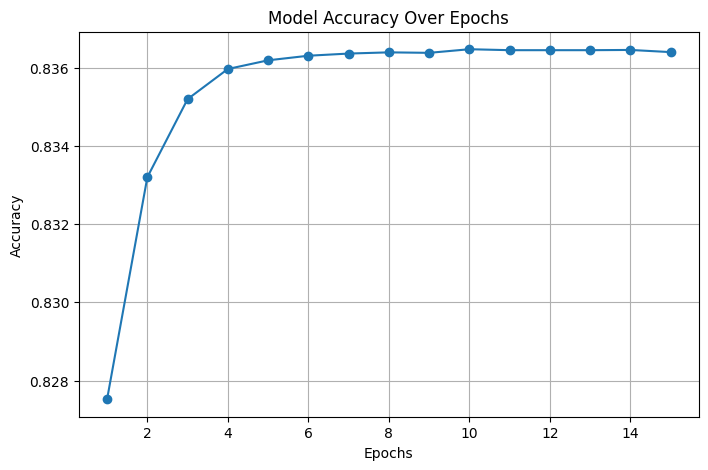

In [38]:
# Accuracy vs epochs
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), accuracy_scores, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.grid()
plt.show()


In [39]:
print(f"\nFinal Model Accuracy: {accuracy_scores[-1]:.4f}")


Final Model Accuracy: 0.8364


In [40]:
# predict on the test data 
y_pred = svm_model.predict(X_test)

In [41]:
# CLassification report 
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.75      0.80     54544
     neutral       0.80      0.91      0.85     53430
    positive       0.86      0.85      0.86     54104

    accuracy                           0.84    162078
   macro avg       0.84      0.84      0.84    162078
weighted avg       0.84      0.84      0.84    162078



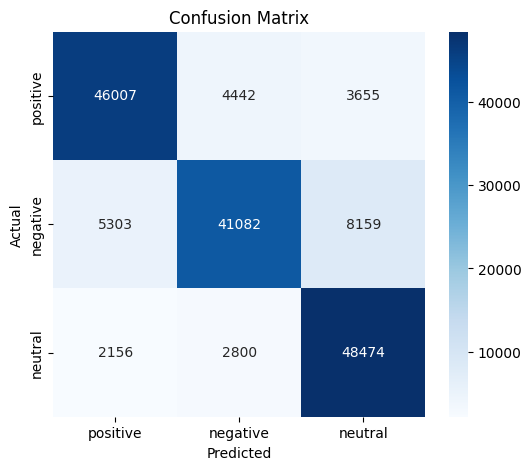

In [42]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative', 'neutral'])

plt.figure(figsize = (6,5))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["positive","negative","neutral"], yticklabels = ["positive","negative","neutral"] )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Conclusions from the confusion matirx heatmap**

* The model correctly predicted 46007 positive sentiments, and 4442 and 3655 were misclassifed as negative and neutral respectively, indicating that the model confuses some positive sentiments for negative. 
* Furhtermore, 41082 were correctly classified as negative while 5303, and 8159 were misclassified as positive and neutral respectively. Additionally, the model confuses some negatives as neutral or positive, indicating that the model struggels with negtive reviews. This is directly correlated with the lower count for negaitve reviews. 
* Additonally the model performed the best in classifying neutral sentiments with 48474 being correctly classified and 2150 being classified as positive and 2800 as negative.

The model has room for improvements, it can be done with increasing the datsset for negative reviews, which can be achieved by using oversampling techniques like SMOTE, where data can be synthesised. Further improvements can be made by reducing the misclassification between negative and neutral reviews. This can be achieved by using word embeddings like **Word2Vec**, insead of using **TF-IDF**. 

In [43]:
# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8364059280099705
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.75      0.80     54544
     neutral       0.80      0.91      0.85     53430
    positive       0.86      0.85      0.86     54104

    accuracy                           0.84    162078
   macro avg       0.84      0.84      0.84    162078
weighted avg       0.84      0.84      0.84    162078



In [44]:
#Running the model on the full dataset

full_model  = SGDClassifier (
    loss = 'hinge',
    max_iter = 1,
    tol = None,
    random_state = 1,
    warm_start = True, 
    n_jobs = -1,
    learning_rate = 'adaptive',
    eta0 = 0.01
)

epochs = 50
accuracy_scrs = []

# We are using partial_fit, because SGDClassifier.fit() does not support progress tracking.
for epoch in tqdm(range(epochs), desc="Training Progress:"):
    full_model.partial_fit(X, y, classes=np.unique(y)) # Extracting the unique values, instead of hardcoded labels, as we did with traing data. 
    y_full_pred = full_model.predict(X)
    acc_full = accuracy_score(y, y_full_pred)
    accuracy_scrs.append(acc_full)
    tqdm.write(f"Epoch {epoch+1}: Accuracy = {acc_full:.4f}")

Training Progress::   2%|▏         | 1/50 [00:10<08:20, 10.21s/it]

Epoch 1: Accuracy = 0.8831


Training Progress::   4%|▍         | 2/50 [00:20<08:07, 10.15s/it]

Epoch 2: Accuracy = 0.8851


Training Progress::   6%|▌         | 3/50 [00:30<07:57, 10.16s/it]

Epoch 3: Accuracy = 0.8852


Training Progress::   8%|▊         | 4/50 [00:40<07:47, 10.15s/it]

Epoch 4: Accuracy = 0.8852


Training Progress::  10%|█         | 5/50 [00:50<07:34, 10.10s/it]

Epoch 5: Accuracy = 0.8852


Training Progress::  12%|█▏        | 6/50 [01:00<07:26, 10.16s/it]

Epoch 6: Accuracy = 0.8852


Training Progress::  14%|█▍        | 7/50 [01:11<07:15, 10.14s/it]

Epoch 7: Accuracy = 0.8852


Training Progress::  16%|█▌        | 8/50 [01:21<07:07, 10.17s/it]

Epoch 8: Accuracy = 0.8852


Training Progress::  18%|█▊        | 9/50 [01:31<06:58, 10.20s/it]

Epoch 9: Accuracy = 0.8852


Training Progress::  20%|██        | 10/50 [01:41<06:45, 10.13s/it]

Epoch 10: Accuracy = 0.8852


Training Progress::  22%|██▏       | 11/50 [01:51<06:35, 10.14s/it]

Epoch 11: Accuracy = 0.8852


Training Progress::  24%|██▍       | 12/50 [02:02<06:28, 10.22s/it]

Epoch 12: Accuracy = 0.8852


Training Progress::  26%|██▌       | 13/50 [02:12<06:20, 10.29s/it]

Epoch 13: Accuracy = 0.8852


Training Progress::  28%|██▊       | 14/50 [02:23<06:14, 10.39s/it]

Epoch 14: Accuracy = 0.8852


Training Progress::  30%|███       | 15/50 [02:33<06:04, 10.40s/it]

Epoch 15: Accuracy = 0.8852


Training Progress::  32%|███▏      | 16/50 [02:43<05:49, 10.28s/it]

Epoch 16: Accuracy = 0.8852


Training Progress::  34%|███▍      | 17/50 [02:53<05:35, 10.17s/it]

Epoch 17: Accuracy = 0.8852


Training Progress::  36%|███▌      | 18/50 [03:03<05:23, 10.10s/it]

Epoch 18: Accuracy = 0.8852


Training Progress::  38%|███▊      | 19/50 [03:13<05:12, 10.08s/it]

Epoch 19: Accuracy = 0.8852


Training Progress::  40%|████      | 20/50 [03:23<05:01, 10.04s/it]

Epoch 20: Accuracy = 0.8852


Training Progress::  42%|████▏     | 21/50 [03:33<04:49,  9.97s/it]

Epoch 21: Accuracy = 0.8852


Training Progress::  44%|████▍     | 22/50 [03:43<04:39,  9.99s/it]

Epoch 22: Accuracy = 0.8852


Training Progress::  46%|████▌     | 23/50 [03:53<04:29,  9.98s/it]

Epoch 23: Accuracy = 0.8852


Training Progress::  48%|████▊     | 24/50 [04:03<04:19,  9.99s/it]

Epoch 24: Accuracy = 0.8852


Training Progress::  50%|█████     | 25/50 [04:13<04:11, 10.05s/it]

Epoch 25: Accuracy = 0.8852


Training Progress::  52%|█████▏    | 26/50 [04:23<04:00, 10.02s/it]

Epoch 26: Accuracy = 0.8852


Training Progress::  54%|█████▍    | 27/50 [04:33<03:50, 10.00s/it]

Epoch 27: Accuracy = 0.8852


Training Progress::  56%|█████▌    | 28/50 [04:42<03:37,  9.90s/it]

Epoch 28: Accuracy = 0.8852


Training Progress::  58%|█████▊    | 29/50 [04:52<03:27,  9.88s/it]

Epoch 29: Accuracy = 0.8852


Training Progress::  60%|██████    | 30/50 [05:02<03:18,  9.94s/it]

Epoch 30: Accuracy = 0.8852


Training Progress::  62%|██████▏   | 31/50 [05:12<03:07,  9.87s/it]

Epoch 31: Accuracy = 0.8852


Training Progress::  64%|██████▍   | 32/50 [05:22<02:57,  9.85s/it]

Epoch 32: Accuracy = 0.8852


Training Progress::  66%|██████▌   | 33/50 [05:32<02:47,  9.83s/it]

Epoch 33: Accuracy = 0.8852


Training Progress::  68%|██████▊   | 34/50 [05:41<02:37,  9.83s/it]

Epoch 34: Accuracy = 0.8852


Training Progress::  70%|███████   | 35/50 [05:51<02:27,  9.86s/it]

Epoch 35: Accuracy = 0.8852


Training Progress::  72%|███████▏  | 36/50 [06:02<02:19,  9.97s/it]

Epoch 36: Accuracy = 0.8852


Training Progress::  74%|███████▍  | 37/50 [06:12<02:10, 10.07s/it]

Epoch 37: Accuracy = 0.8852


Training Progress::  76%|███████▌  | 38/50 [06:22<01:59,  9.96s/it]

Epoch 38: Accuracy = 0.8852


Training Progress::  78%|███████▊  | 39/50 [06:31<01:48,  9.90s/it]

Epoch 39: Accuracy = 0.8852


Training Progress::  80%|████████  | 40/50 [06:41<01:38,  9.87s/it]

Epoch 40: Accuracy = 0.8852


Training Progress::  82%|████████▏ | 41/50 [06:51<01:28,  9.79s/it]

Epoch 41: Accuracy = 0.8852


Training Progress::  84%|████████▍ | 42/50 [07:00<01:17,  9.74s/it]

Epoch 42: Accuracy = 0.8852


Training Progress::  86%|████████▌ | 43/50 [07:10<01:08,  9.75s/it]

Epoch 43: Accuracy = 0.8852


Training Progress::  88%|████████▊ | 44/50 [07:20<00:58,  9.73s/it]

Epoch 44: Accuracy = 0.8852


Training Progress::  90%|█████████ | 45/50 [07:29<00:48,  9.67s/it]

Epoch 45: Accuracy = 0.8852


Training Progress::  92%|█████████▏| 46/50 [07:39<00:38,  9.68s/it]

Epoch 46: Accuracy = 0.8852


Training Progress::  94%|█████████▍| 47/50 [07:49<00:28,  9.66s/it]

Epoch 47: Accuracy = 0.8852


Training Progress::  96%|█████████▌| 48/50 [07:58<00:19,  9.62s/it]

Epoch 48: Accuracy = 0.8852


Training Progress::  98%|█████████▊| 49/50 [08:08<00:09,  9.61s/it]

Epoch 49: Accuracy = 0.8852


Training Progress:: 100%|██████████| 50/50 [08:18<00:00,  9.96s/it]

Epoch 50: Accuracy = 0.8852


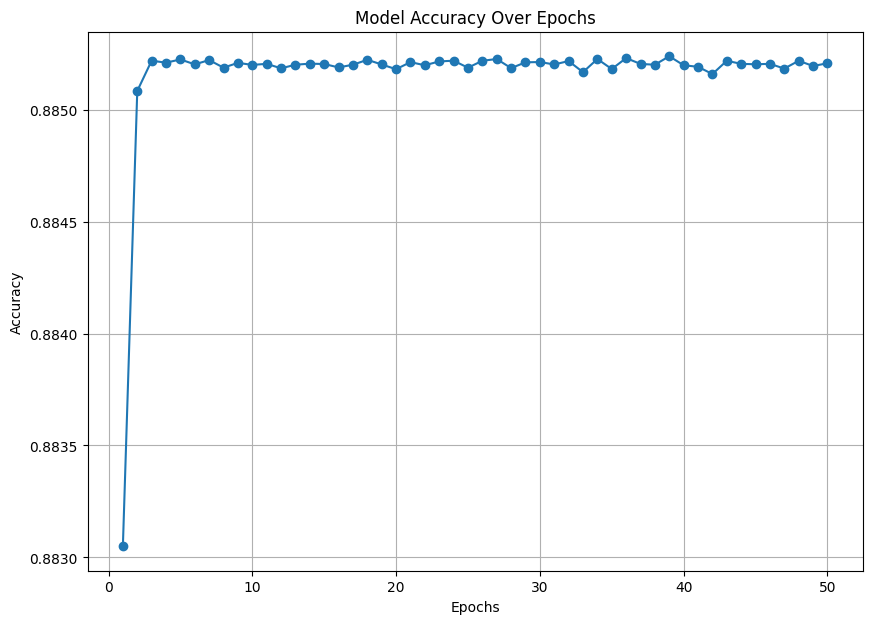

In [45]:
# Visualising the accuracy over time
plt.figure(figsize = (10,7))
plt.plot(range(1, epochs+1), accuracy_scrs, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.grid()
plt.show()

In [46]:
# Generating the clasification report
report = classification_report(y, y_full_pred, target_names=['negative', 'neutral', 'positive'])
print("Classification report for Full Dataset Model:\n")
print(report)

Classification report for Full Dataset Model:

              precision    recall  f1-score   support

    negative       0.87      0.40      0.54    272611
     neutral       0.84      0.63      0.72    267648
    positive       0.89      0.99      0.94   1960680

    accuracy                           0.89   2500939
   macro avg       0.87      0.67      0.73   2500939
weighted avg       0.88      0.89      0.87   2500939



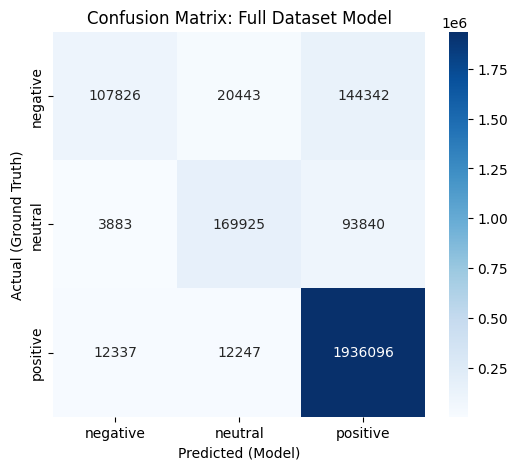

In [47]:
cm_full = confusion_matrix(y, y_full_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted (Model)')
plt.ylabel('Actual (Ground Truth)')
plt.title('Confusion Matrix: Full Dataset Model')
plt.show()

**As expected the model is shows a heavy bias towards positive reviews due to the massive difference in the number of positive reviews when compared to the negative and neutral** 
Thus justifying the decision of undersmapling the positive review data for the test data. 

# Comapring the model predictions with VADER

In [48]:
ml_data.head()

,rating,title,text,asin,parent_asin,user_id,date,time,neg,neu,pos,compound,vader_sentiment,sentiment
0,5,Pretty locket,I think this locket is really pretty. The insi...,B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09,00:06:34.489000,0.039,0.750,0.211,0.8532,positive,positive
1,5,A,Great,B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20,01:04:06.701000,0.000,0.000,1.000,0.6249,positive,positive
2,2,Two Stars,One of the stones fell out within the first 2 ...,B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23,01:33:48,0.000,1.000,0.000,0.0000,neutral,neutral
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31,20:57:27.095000,0.325,0.574,0.100,-0.6908,negative,negative
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13,14:29:26,0.000,0.684,0.316,0.9675,positive,positive


In [49]:
ml_data.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id', 'date',
       'time', 'neg', 'neu', 'pos', 'compound', 'vader_sentiment',
       'sentiment'],
      dtype='object')

In [50]:
# Making sure the data shapes are matching 
print("Shape of ml_data:",ml_data.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)

Shape of ml_data: (2500939, 14)
Shape of y_test: (162078,)
Shape of y_pred: (162078,)


In [51]:
# Creating a separate dataframe to use for comparing the model values with that of VADER analysis. 

comparison_df = pd.DataFrame({
    "VADER_Sentiment": ml_data.loc[y_test.index, "vader_sentiment"],  # Categorical labels from VADER
    "ML_Model_Sentiment": y_pred  # Categorical predictions from ML model
})

# Display first few rows
print(comparison_df.head())



       VADER_Sentiment ML_Model_Sentiment
578166        positive            neutral
773552        negative           positive
236115        positive           negative
592982        positive            neutral
11299         positive           negative


In [52]:
# Calculating the percentage of matching sentiment predictions
agreement = (comparison_df["VADER_Sentiment"] == comparison_df["ML_Model_Sentiment"]).mean()
print(f"Agreement Between VADER and ML Model: {agreement:.2%}")

Agreement Between VADER and ML Model: 32.93%


In [53]:
from sklearn.preprocessing import LabelEncoder

# Initializing label encoder
label_encoder = LabelEncoder()

# Encode VADER Sentiment Labels
comparison_df["VADER_Encoded"] = label_encoder.fit_transform(comparison_df["VADER_Sentiment"])

# Encode ML Model Sentiment Labels (Using same encoder to maintain consistency)
comparison_df["ML_Model_Encoded"] = label_encoder.transform(comparison_df["ML_Model_Sentiment"])

# Display the first few rows
print(comparison_df.head())
print("\nEncoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

       VADER_Sentiment ML_Model_Sentiment  VADER_Encoded  ML_Model_Encoded
578166        positive            neutral              2                 1
773552        negative           positive              0                 2
236115        positive           negative              2                 0
592982        positive            neutral              2                 1
11299         positive           negative              2                 0

Encoding Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [54]:
print("Classification Report: VADER vs. ML Model")
print(classification_report(comparison_df["VADER_Encoded"], comparison_df["ML_Model_Encoded"], target_names=label_encoder.classes_))

Classification Report: VADER vs. ML Model
              precision    recall  f1-score   support

    negative       0.10      0.30      0.15     16126
     neutral       0.10      0.37      0.15     15650
    positive       0.80      0.33      0.47    130302

    accuracy                           0.33    162078
   macro avg       0.33      0.33      0.26    162078
weighted avg       0.66      0.33      0.40    162078



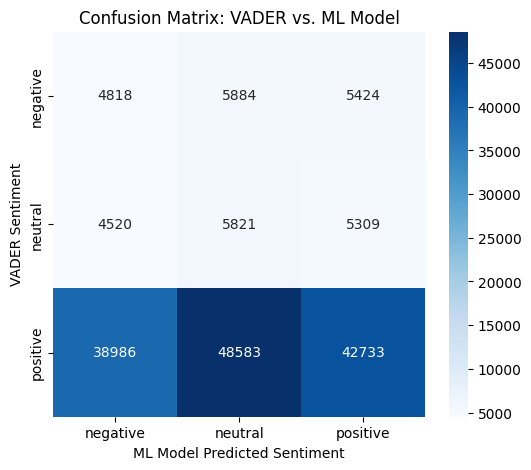

In [55]:
conf_matrix = confusion_matrix(comparison_df["VADER_Encoded"], comparison_df["ML_Model_Encoded"])

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("ML Model Predicted Sentiment")
plt.ylabel("VADER Sentiment")
plt.title("Confusion Matrix: VADER vs. ML Model")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


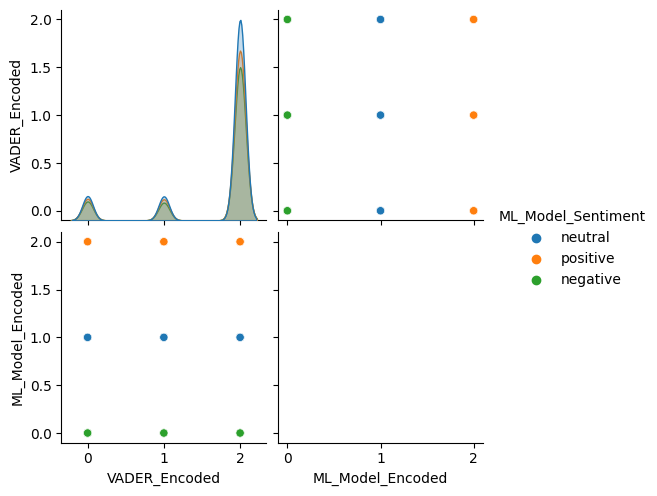

In [56]:
sns.pairplot(comparison_df, vars=["VADER_Encoded", "ML_Model_Encoded"], hue="ML_Model_Sentiment")
plt.show()

# **Things I learned from my first Meachine Learning model training and sentiment anlysis**

**Observations from the Classification report**
* While the Initial direction of using VADER bag if word approach was correct. It provided me with numerical data for positive, negative, neutral and and overall compound score for each review. 
* As seen above the ML model when compared to VADER based analysis performs significantly worse, with its very poor precision for negative and neutral sentiments (0.10), the model incorrectly classifies a large number of negative or neutral sentiments as positive. The poor performance is furhter indicated by low recall for all sentiments - less than 40%, a large number of true negaitves are classified as positives. 
* Furhtermore, the model favors predicting positive reviews as seen with the help of high precision sentiment (0.80), however the low recall of 0.33 indicates that it does not classify many of them correctly.
* The Macro Avg F1-Score of 0.26, indicates the performance is unbalanced.

**Observations from the confusion matrix**

* The model misclassifes 38,986 negaitve and 48,583 neutral sentiments as positive, aligning with the high precision value and low recall value.
* The models poor performance in diffrentiating negative and neutral sentiments indicates a dataset imbalance or feature reprentation issue, this is also in line with 1.9M reviews being positive and about 27k and 26K reviews being negaitve and neutral. This skew in data was attemped to address by undersampling the positive data for the training of the ML model. The issue could have be the method applied of TF-IDF, perhaps Word2Vec, BERT, or GloVe would have perfomed better.

**Overall Conclusions**

* The model is heavly biased towards predicting "positive" sentiments and fails to correctly classify "negative" and "neutral" reviews.
* The biggest issue is the low recall of negative and neutral sentiments which is leading to misclassification.
  

# **How can the performance of the model be improved?**

* Firstly the imbalnce in the dataset should be addressed, either by underfittingt the positive reviews or overfitting the negative and neutral reviews.
* Instead of TF-IDF, methods like Word2Vec, BERT or GloVE would demostrate better understanding of the text, allowing to capture deeper meaning instead of just word frequency.
* I could try models like RandomForest or Neural Networks instead of using SVM.

**To improve VADER sentiment labeling, as VADER assigns a continous compound score, I could adjust the decision threshold to prevent over-classification of positive reviews.**

# **In a nutshell**
**ML underperformance reasons**
* Imbalanced Dataset- large number of positive reviews
* TF-IDF does not capture meaninig well leading to poor feature representaion.
* Inefficient thresholding

**How to improve it?**
* Balance the dataset.
* Using deep text embeddings like **BERT**, **Word2Vec**.
* Trying better models like **Random Forest** or **Neural Network**
* Optimise decision threshold for classification.


# **Citation**
@article{hou2024bridging,
  title={Bridging Language and Items for Retrieval and Recommendation},
  author={Hou, Yupeng and Li, Jiacheng and He, Zhankui and Yan, An and Chen, Xiusi and McAuley, Julian},
  journal={arXiv preprint arXiv:2403.03952},
  year={2024}
}